Process 5 way breakdown

In [17]:
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import torch
from scipy import stats
import sklearn
from sklearn import inspection

sys.path.insert(0, 'src')
from utils.utils import read_lists, load_image, ensure_dir, write_lists, informal_log
from utils.visualizations import plot # histogram, show_image_rows, bar_graph, pie_chart
# from utils.df_utils import convert_string_columns, string_to_numpy, string_to_list
from utils.attribute_utils import hyperparam_search
from utils.metric_utils import sort_and_bin_df, calculate_bin_agreement, plot_alignment, run_feature_importance_trial, correlated_variables, print_summary, filter_df, string_to_list, plot_metric_v_inputs, get_coefficient_significance
import model.metric as module_metric


# Setup

In [3]:
# Make separate CSVs from master CSV
master_csv_path = 'saved/ADE20K/survey_results/processed_results_300_samples.csv'
df = pd.read_csv(master_csv_path)
print("Read master CSV from {}".format(master_csv_path))
      
# Create list of DFs for each partition
dfs = []
# Case 1: model = explainer = human 
df1 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] == df['human_predictions'])]
dfs.append(df1)
# Case 2: model = explainer != human
df2 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
dfs.append(df2)

# Case 3: model = human != explainer
df3 = df[(df['model_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
dfs.append(df3)

# Case 4: explainer = human != model
df4 = df[(df['explainer_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
dfs.append(df4)

# Case 5: explainer != model != human
df5 = df[(df['explainer_predictions'] != df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
dfs.append(df5)

# Check that no rows overlap, all mutually exclusive
for i in range(len(dfs) - 1):
    for j in range(i+1, len(dfs)):
        overlap = set(dfs[i]['filename']) & set(dfs[j]['filename'])
        assert len(overlap) == 0
            
print("Created df partitions")

groups_save_dir = os.path.join(os.path.dirname(master_csv_path), 'group_csvs')
ensure_dir(groups_save_dir)

# Check if filenames are in the save directory
n_groups = 5
filenames = ['group_{}.csv'.format(i) for i in range(1, 6)]
dir_contents = os.listdir(groups_save_dir)
dir_empty = True
for file in filenames:
    if file in dir_contents:
        dir_empty = False
if not dir_empty:
    print("Directory {} is not empty. Remove contents to save group CSVs".format(groups_save_dir))
else:
    
    for idx, cur_df in enumerate(dfs):
        cur_csv_save_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(idx+1))
        cur_df.to_csv(cur_csv_save_path)
        print("Saved CSV for group {} to {}".format(idx+1, cur_csv_save_path))

Read master CSV from saved/ADE20K/survey_results/processed_results_300_samples.csv
Created df partitions
Directory saved/ADE20K/survey_results/group_csvs is not empty. Remove contents to save group CSVs


#### Join dataframes together, Make save directories

In [33]:
# group_nums = [1, 3]  # model and human are aligned
group_nums = [2, 4, 5]

cur_df_list = []
for group_num in group_nums:
    csv_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(group_num))
    cur_df_list.append(pd.read_csv(csv_path))
    cur_df = pd.concat(cur_df_list)

print("Joined groups {} to form dataframe with {} rows".format(group_nums, len(cur_df)))

# Make directory for this grouping
group_name = 'group'
for i in group_nums:
    group_name += '_{}'.format(i)
cur_group_save_dir = os.path.join(groups_save_dir, group_name)
ensure_dir(cur_group_save_dir)
print("Created directory for groups {} at {}".format(group_nums, cur_group_save_dir))
graph_save_dir = os.path.join(cur_group_save_dir, 'graphs')
ensure_dir(graph_save_dir)
print("Created directory for graphs at {}".format(group_nums, cur_group_save_dir))

# Save current dataframe
cur_csv_save_path = os.path.join(cur_group_save_dir, '{}.csv'.format(group_name))
if not os.path.exists(cur_csv_save_path):
    cur_df.to_csv(cur_csv_save_path)
    print("Saved csv for groups {} at {}".format(group_nums, cur_csv_save_path))
else:
    print("CSV at {} already exists.".format(cur_csv_save_path))

Joined groups [2, 4, 5] to form dataframe with 106 rows
Created directory for groups [2, 4, 5] at saved/ADE20K/survey_results/group_csvs/group_2_4_5
Created directory for graphs at [2, 4, 5]
Saved csv for groups [2, 4, 5] at saved/ADE20K/survey_results/group_csvs/group_2_4_5/group_2_4_5.csv


# Process

#### Sensitivity study of n_bins on Pearsons for individual groups in current breakdown

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

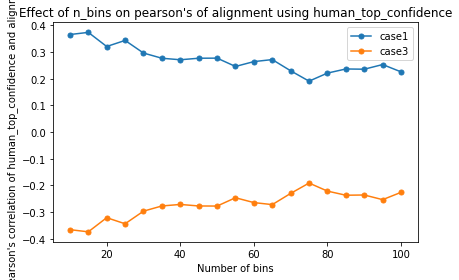

<Figure size 432x288 with 0 Axes>

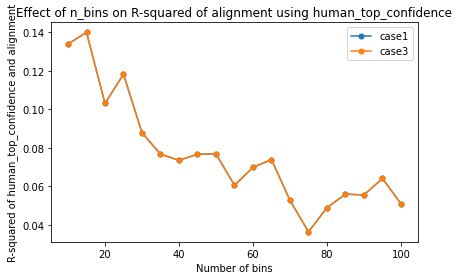

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

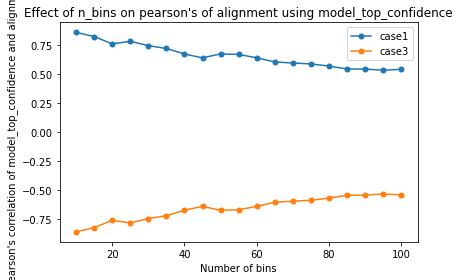

<Figure size 432x288 with 0 Axes>

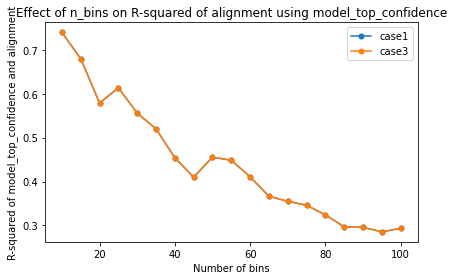

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

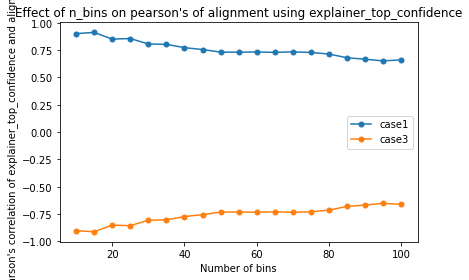

<Figure size 432x288 with 0 Axes>

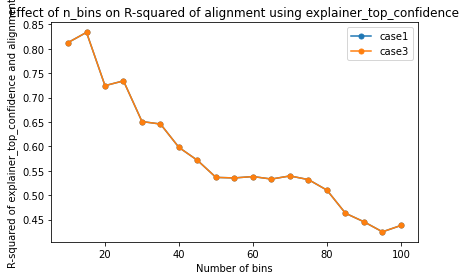

In [5]:
sensitivity_graph_save_dir = os.path.join(graph_save_dir, 'n_bin_sensitivity')
ensure_dir(sensitivity_graph_save_dir)
for iv_agent in ['human', 'model', 'explainer']:
    iv_names = ['{}_top_confidence'.format(iv_agent),
                '{}_t2c'.format(iv_agent),
                '{}_entropy'.format(iv_agent)]
    # agent_pairs = [
    #     ('human', 'explainer'),
    #     ('human', 'model'),
    #     ('model', 'explainer')]
    cases = ['case{}'.format(i) for i in group_nums]
    print(cases)
    
    all_pearsons = []
    all_r_squared = []
    n_bins = [i for i in range(10, 101, 5)]
    print("n_bins: {}".format(n_bins))

    for case_idx, case in enumerate(cases):
        # agent1, agent2 = pair
        cur_pearsons = []
        cur_r_squared = []
        for n_bin in n_bins:
            bin_rows, iv_means, iv_stds, iv_ses = sort_and_bin_df(
                df=cur_df,
                sort_columns=iv_names, 
                n_bins=n_bin)
            cur_agreements, agreement_stds, agreement_ses = calculate_bin_agreement(
                bin_rows=bin_rows,
                column_name=case)
            pearsons = stats.pearsonr(iv_means, cur_agreements).statistic
            cur_pearsons.append(pearsons)
            # slope, yint, r, p, std_err = stats.linregress(iv_means, cur_agreement)
            r_squared = pearsons ** 2
            cur_r_squared.append(r_squared)
        all_pearsons.append(cur_pearsons)
        all_r_squared.append(cur_r_squared)

    # Plot pearsons v n_bins
    plot(
        xs=[n_bins for i in range(len(cases))],
        ys=all_pearsons,
        labels=cases,
        xlabel='Number of bins',
        ylabel="Pearson's correlation of {} and alignment".format(iv_names[0]),
        title='Effect of n_bins on pearson\'s of alignment using {}'.format(
            iv_names[0]),
        show=True,
        save_path=os.path.join(sensitivity_graph_save_dir, 'nbins_pearsons_{}.png'.format(iv_names[0])))


    # Plot r-squared v n_bins
    plot(
        xs=[n_bins for i in range(len(cases))],
        ys=all_r_squared,
        labels=cases,
        xlabel='Number of bins',
        ylabel="R-squared of {} and alignment".format(iv_names[0]),
        title='Effect of n_bins on R-squared of alignment using {}'.format(
            iv_names[0]),
        show=True,
        save_path=os.path.join(sensitivity_graph_save_dir, 'nbins_rsquared_{}.png'.format(iv_names[0])))

#### Let's just look at groups 1,3 in the 5 way breakdown

##### Linear Regression

Figure saved to saved/ADE20K/survey_results/group_csvs/group_1_3/graphs/human-explainer_alignment_v_t2c.png


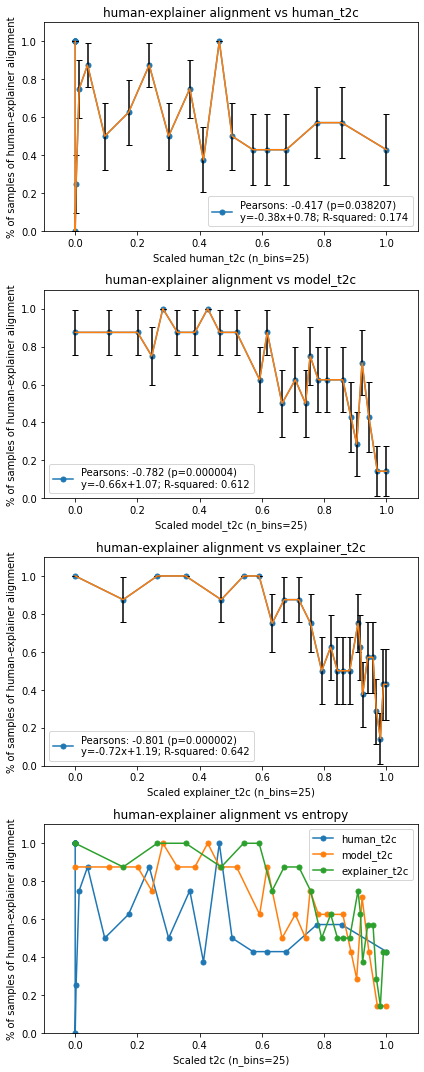

Figure saved to saved/ADE20K/survey_results/group_csvs/group_1_3/graphs/model-explainer_alignment_v_t2c.png


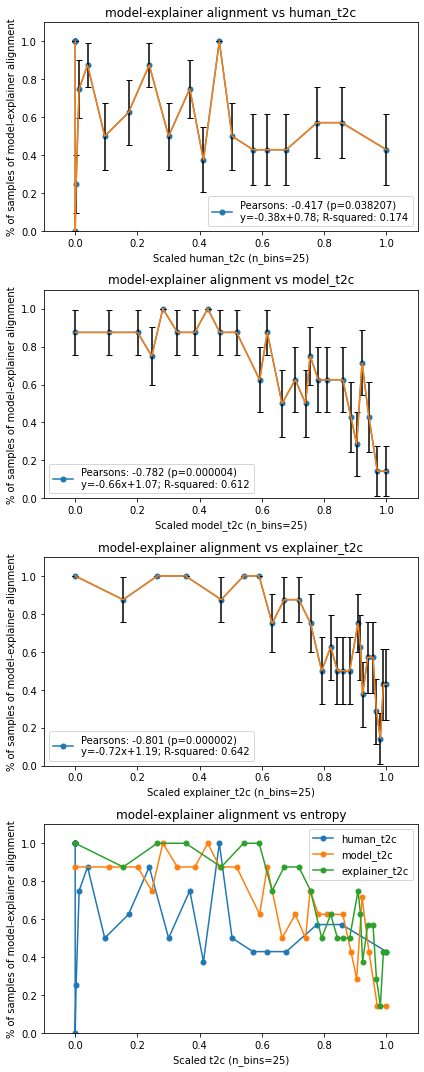

Pearsons between variance of confusion and variance of alignment: -0.193 (p=0.017723)
y=-0.18x+0.13; R-squared: 0.037


In [7]:
agent_pairs = [
    ('human', 'explainer'),
    # ('human', 'model'),
    ('model', 'explainer')
]
agents = ['human', 'model', 'explainer']

plot_xerr = False
plot_yerr = True

# confusion_templates = ['{}_entropy', '{}_t2c']
confusion_templates = ['{}_t2c', '{}_entropy']
# confusion_templates = ['{}_top_confidence', '{}_t2c', '{}_entropy']
x_variance = []
y_variance = []
if 'entropy' in confusion_templates[0]:
    n_bins = 20
elif 't2c' in confusion_templates[0]:
    n_bins = 25
elif 'top_confidence' in confusion_templates[0]:
    n_bins = 25
else:
    raise ValueError("Confusion type in '{}' not supported.".format(confusion_templates[0]))
for agent_pair in agent_pairs:
    agent1, agent2 = agent_pair
    confusions = []
    agreements = []
    fig, axs = plt.subplots(4, 1, figsize=(6, 15))
    
    # Separate plot for confusion from each agent
    for idx, agent in enumerate(agents):
        confusion_names = [confusion_template.format(agent) for confusion_template in confusion_templates]
        ax, iv_means, iv_stds, cur_agreement, agreement_ses, ylabel = plot_alignment(
            df=cur_df,
            confusion_names=confusion_names,
            n_bins=n_bins,
            fig=fig,
            ax=axs[idx],
            alignment_col_name=None,
            agent1=agent1,
            agent2=agent2,
            plot_xerr=plot_xerr,
            plot_yerr=plot_yerr)

        confusions.append(iv_means)
        agreements.append(cur_agreement)

        x_variance.append(iv_stds)
        y_variance.append(agreement_ses)
        axs[idx] = ax
    
    xlabel = 'Scaled {} (n_bins={})'.format(confusion_templates[0].split('_')[1], n_bins)
    title = '{}-{} alignment vs entropy'.format(agent1, agent2)
    fig, ax = plot(
        xs=confusions,
        ys=agreements,
        fig=fig,
        ax=axs[-1],
        labels=[confusion_templates[0].format(agent) for agent in agents],
        xlabel=xlabel,
        ylabel=ylabel,
        ylimits=[0, 1.1],
        xlimits=[-0.1, 1.1],
        title=title,
        show=False)
    axs[-1] = ax
    save_path = os.path.join(graph_save_dir, '{}-{}_alignment_v_{}.png'.format(agent1, agent2, confusion_templates[0].split('_')[1]))
    plt.savefig(save_path)
    print("Figure saved to {}".format(save_path))
    plt.show()
    
x_variance = np.concatenate(x_variance, axis=0)
y_variance = np.concatenate(y_variance, axis=0)

slope, yint, r, p, std_err = stats.linregress(
    x=x_variance,
    y=y_variance)
print('Pearsons between variance of confusion and variance of alignment: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
        r, p, slope, yint, r**2))


#### Logistic Regression Classifiers

In [44]:
# Set constants
seed = 1
penalty = 'l2'
solver = 'lbfgs'
class_weight = 'balanced'
logistic_regression_args = {
    'penalty': penalty,
    'solver': solver,
    'class_weight': class_weight
}

metric_names = ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss']

# Split dataframe into train/test
train_split = 0.7
# shuffled = cur_df.sample(frac=1, random_state=seed)
train_rows = cur_df.sample(frac=train_split, random_state=seed)
val_rows = cur_df.drop(train_rows.index)
assert len(set(train_rows.index).intersection(set(val_rows.index))) == 0

# Create x, y data
iv_types = ['top_confidence', 'entropy', 't2c']
agents = ['human', 'model', 'explainer']
agent_pairs = [
    ('human', 'explainer'),
    ('model', 'explainer'),
    # ('human', 'model')
]

agents_list = [
    ['human'],
    ['model'],
    ['explainer'],
    ['human', 'explainer'],
    ['human', 'model'],
    ['model', 'explainer'],
    ['human', 'explainer', 'model']
]

for agent1, agent2 in agent_pairs:
    print("{}-{} alignment in training: {:.2f} \t in test: {:.2f}".format(
        agent1, agent2,
        100 * len(train_rows[train_rows['{}_{}_alignment'.format(agent1, agent2)] == 1]) / len(train_rows),
        100 * len(val_rows[val_rows['{}_{}_alignment'.format(agent1, agent2)] == 1]) / len(val_rows)))
        

8     False
35    False
1     False
6     False
39    False
Name: case1, dtype: bool
human-explainer alignment in training: 12.16 	 in test: 8.33
model-explainer alignment in training: 52.70 	 in test: 58.33


In [45]:
# List to store results from all trials
trials = []
clfs = []
trial_keys = []
trial_idx = 1
n_trials = len(iv_types) * len(agents_list) * len(agent_pairs)
for iv_type in iv_types:
    for idx, agents in enumerate(agents_list):
        x_names = ['{}_{}'.format(agent, iv_type) for agent in agents]
        for x_name in x_names:
            assert x_name in cur_df.columns 
        
        for agent1, agent2 in agent_pairs:
            # set seed 
            seed = 0
            y_names = ['{}_{}_alignment'.format(agent1, agent2)]
            print("Itr {}/{}: IV: {} DV: {}".format(trial_idx, n_trials, x_names, y_names))
            trial_return = run_feature_importance_trial(
                train_rows=train_rows,
                val_rows=val_rows,
                x_names=x_names,
                y_names=y_names,
                metric_names=metric_names,
                trial_id=trial_idx-1,
                logistic_regression_args=logistic_regression_args,
                seed=seed)
            clf = trial_return['clf']
            cur_data = trial_return['cur_data']
            trial_key = trial_return['trial_key']
            
            clfs.append(clf)
            trials.append(cur_data)
            trial_keys.append(trial_key)
            trial_idx += 1


Itr 1/42: IV: ['human_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.5833333333333334 Regularization: 0.001
Best accuracy: 0.6666666666666666 Regularization: 5
Learned classifier to predict ['human_explainer_alignment'] from ['human_top_confidence']
Coefficients: [[3.95821694]]
Predictions:
0: 58.33
1: 41.67
Itr 2/42: IV: ['human_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.5833333333333334 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['human_top_confidence']
Coefficients: [[-0.0013144]]
Predictions:
0: 50.00
1: 50.00
Itr 3/42: IV: ['model_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.5833333333333334 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['model_top_confidence']
Coefficients: [[0.00260685]]
Predictions:
0: 50.00
1: 50.00
Itr 4/42: IV: ['model_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.6666666666666666 Regu

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 20/42: IV: ['explainer_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.3333333333333333 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['explainer_entropy']
Coefficients: [[-0.00068677]]
Predictions:
0: 58.33
1: 41.67
Itr 21/42: IV: ['human_entropy', 'explainer_entropy'] DV: ['human_explainer_alignment']
Best accuracy: 0.6666666666666666 Regularization: 0.001
Best accuracy: 0.75 Regularization: 3
Learned classifier to predict ['human_explainer_alignment'] from ['human_entropy', 'explainer_entropy']
Coefficients: [[-3.08603038 -0.01980042]]
Predictions:
0: 66.67
1: 33.33
Itr 22/42: IV: ['human_entropy', 'explainer_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.4166666666666667 Regularization: 0.001
Best accuracy: 0.5 Regularization: 1
Learned classifier to predict ['model_explainer_alignment'] from ['human_entropy', 'explainer_entropy']
Coefficients: [[ 0.51946795 -0.41864219]]
Predictions:
0: 75.00
1: 25.00
Itr 23/4

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 27/42: IV: ['human_entropy', 'explainer_entropy', 'model_entropy'] DV: ['human_explainer_alignment']
Best accuracy: 0.5833333333333334 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['human_entropy', 'explainer_entropy', 'model_entropy']
Coefficients: [[-0.00406693 -0.00090414 -0.00335512]]
Predictions:
0: 50.00
1: 50.00
Itr 28/42: IV: ['human_entropy', 'explainer_entropy', 'model_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.5833333333333334 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['human_entropy', 'explainer_entropy', 'model_entropy']
Coefficients: [[ 0.00108299 -0.00068568 -0.00011213]]
Predictions:
0: 83.33
1: 16.67
Itr 29/42: IV: ['human_t2c'] DV: ['human_explainer_alignment']
Best accuracy: 0.75 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['human_t2c']
Coefficients: [[-0.00485009]]
Predictions:
0: 66.67
1: 33.33
Itr 30/42: IV: ['huma

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 34/42: IV: ['explainer_t2c'] DV: ['model_explainer_alignment']
Best accuracy: 0.5833333333333334 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['explainer_t2c']
Coefficients: [[-0.0026576]]
Predictions:
0: 50.00
1: 50.00
Itr 35/42: IV: ['human_t2c', 'explainer_t2c'] DV: ['human_explainer_alignment']
Best accuracy: 0.75 Regularization: 0.001
Best accuracy: 0.8333333333333334 Regularization: 0.5
Learned classifier to predict ['human_explainer_alignment'] from ['human_t2c', 'explainer_t2c']
Coefficients: [[-1.4402932   0.06231802]]
Predictions:
0: 75.00
1: 25.00
Itr 36/42: IV: ['human_t2c', 'explainer_t2c'] DV: ['model_explainer_alignment']
Best accuracy: 0.5 Regularization: 0.001
Best accuracy: 0.5833333333333334 Regularization: 0.5
Learned classifier to predict ['model_explainer_alignment'] from ['human_t2c', 'explainer_t2c']
Coefficients: [[ 0.5374811  -0.87528371]]
Predictions:
0: 33.33
1: 66.67
Itr 37/42: IV: ['human_t2c', 'model_t2c'] DV:

In [37]:
# Create save directory
logreg_save_dir = os.path.join(cur_group_save_dir, 'logreg_results')
ensure_dir(logreg_save_dir)

# Save feature importance results in different forms
logreg_df = pd.DataFrame(trials)
logreg_df_path = os.path.join(logreg_save_dir, 'sensitivity.csv')
logreg_df.to_csv(logreg_df_path)
print("Saved sensitivity results to {}".format(logreg_df_path))

# Write map of trial idx to iv/dv combination
trial_keys_path = os.path.join(logreg_save_dir, 'trial_keys.txt')
write_lists(trial_keys, trial_keys_path)

# Save logistic regression arguments
logreg_args_save_path = os.path.join(logreg_save_dir, 'logreg_args.json')
with open(logreg_args_save_path, 'w') as f:
    json.dump(logistic_regression_args, f)
print("Saved logistic regression arguments to {}".format(logreg_args_save_path))

Saved sensitivity results to saved/ADE20K/survey_results/group_csvs/group_2_4_5/logreg_results/sensitivity.csv
Saved logistic regression arguments to saved/ADE20K/survey_results/group_csvs/group_2_4_5/logreg_results/logreg_args.json


In [38]:
# Obtain correlated pairs 
all_x_names = [
    'human_top_confidence', 'model_top_confidence', 'explainer_top_confidence', 
    'human_entropy', 'model_entropy', 'explainer_entropy', 
    'human_t2c', 'model_t2c', 'explainer_t2c'
]
low_corr_set, med_corr_set, high_corr_set = correlated_variables(
    train_rows=train_rows,
    x_names=all_x_names)

Low correlation pairs (<0.3)
('human_top_confidence', 'model_top_confidence', 0.08351367894966753, 0.47930656680377937)
('human_top_confidence', 'explainer_top_confidence', 0.10198949730784554, 0.38722102684436077)
('human_top_confidence', 'model_entropy', -0.1320127021398848, 0.2622035948400195)
('human_top_confidence', 'explainer_entropy', -0.05965901347269738, 0.6136156107506034)
('human_top_confidence', 'model_t2c', 0.0411384955539754, 0.7278332132642051)
('human_top_confidence', 'explainer_t2c', 0.059793112154329316, 0.6128172423004999)
('model_top_confidence', 'explainer_top_confidence', 0.18901147723065523, 0.10678116159749905)
('model_top_confidence', 'human_entropy', -0.058422325630980626, 0.620999398391763)
('model_top_confidence', 'explainer_entropy', -0.18006664198445016, 0.12473496725290945)
('model_top_confidence', 'human_t2c', 0.013185088386373096, 0.9112228365078497)
('model_top_confidence', 'explainer_t2c', -0.11398741206960382, 0.3335342243524225)
('explainer_top_conf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(human_top_confidence, explainer_top_confidence) has low correlation
(human_top_confidence, model_top_confidence) has low correlation
(model_top_confidence, explainer_top_confidence) has low correlation
Highest accuracy with ['human_top_confidence']: 0.9167


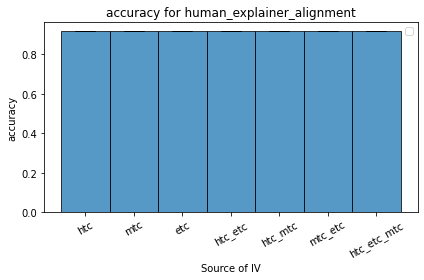

Row index 0
IV: ['human_top_confidence'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.9167
		 'human_top_confidence' sensitivity: 0.0000
	f1: 0.4783
		 'human_top_confidence' sensitivity: 0.0000
Row index 2
IV: ['model_top_confidence'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.9167
		 'model_top_confidence' sensitivity: 0.0000
	f1: 0.4783
		 'model_top_confidence' sensitivity: 0.0000
Row index 4
IV: ['explainer_top_confidence'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.9167
		 'explainer_top_confidence' sensitivity: 0.0000
	f1: 0.4783
		 'explainer_top_confidence' sensitivity: 0.0000
Row index 6
IV: ['human_top_confidence', 'explainer_top_confidence'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.9167
		 'human_top_confidence' sensitivity: 0.0000
		 'explainer_top_confidence' sensitivity: 0.0000
	f1: 0.4783
		 'human_top_confidence' sensitivity: 0.0000
		 'explainer_top_confidence' sensitivity: 0.0000
Row index 8
IV: ['human_top_confiden

In [46]:
logreg_df_path = os.path.join(cur_group_save_dir, 'logreg_results', 'sensitivity.csv')
# logreg_df_path = 'saved/ADE20K/survey_results/group_1_3/logreg_results/sensitivity.csv'
logreg_df = pd.read_csv(logreg_df_path)
ivs = ['top_confidence']
dv = 'human_explainer_alignment'
metrics = ['accuracy', 'f1']
drop_correlated = True

cur_logreg_df = filter_df(logreg_df,
    ivs=ivs,
    dv=dv)

# Drop rows that have correlated variables
if drop_correlated:
    drop_idxs = []
    for idx, row in cur_logreg_df.iterrows():
        row_ivs = string_to_list(row['iv'], dtype='string')
        row_ivs = [word.replace("'", "") for word in row_ivs]
        
        # if len(row_ivs) > 2:
        #     drop_idxs.append(row['Unnamed: 0'])
        if len(row_ivs) == 2:
            var1, var2 = row_ivs
            if (var1, var2) in low_corr_set or (var2, var1) in low_corr_set:
                print("({}, {}) has low correlation".format(var1, var2))
            elif (var1, var2) in med_corr_set or (var2, var1) in med_corr_set:
                print("({}, {}) has moderate correlation".format(var1, var2))
            else:
                drop_idxs.append(row['Unnamed: 0'])
                print("Dropping ({}, {})".format(var1, var2))
    cur_logreg_df = cur_logreg_df.drop(drop_idxs, axis=0)

log_path = 'temp/temp.txt'
highest_acc_row = cur_logreg_df.loc[cur_logreg_df['accuracy'].idxmax()]
print("Highest accuracy with {}: {:.4f}".format(
    highest_acc_row['iv'],
    highest_acc_row['accuracy']))

plot_metric_v_inputs(
    df=cur_logreg_df,
    ivs=ivs,
    dv=dv,
    graph_metric='accuracy')
print_summary(
    df=cur_logreg_df,
    metrics=metrics,
    log_path=log_path)

#### Logistic Regression for predicting which of the 5 way break down

In [14]:
# Start with just groups 2,4,5
cur_df_path = 'saved/ADE20K/survey_results/group_csvs/group_2_4_5/group_2_4_5.csv'
cur_df = pd.read_csv(cur_df_path)
cur_group_save_dir = os.path.dirname(cur_df_path)

one_hot_labels = cur_df[['case2', 'case4', 'case5']].to_numpy()
for row in one_hot_labels:
    assert np.sum(row) == 1
labels = np.argmax(one_hot_labels, axis=1)
'''
0 -> 2
1 -> 4
2 -> 5
'''
cur_df['labels'] = labels

unique_labels, unique_counts = np.unique(labels, return_counts=True)
for l, c in zip(unique_labels, unique_counts):
    print("Label {} has {} occurrences".format(l, c))

Label 0 has 58 occurrences
Label 1 has 13 occurrences
Label 2 has 35 occurrences


In [6]:
# Set constants
seed = 1
penalty = 'l2'
solver = 'lbfgs'
class_weight = 'balanced'
multi_class = 'ovr'
logistic_regression_args = {
    'penalty': penalty,
    'solver': solver,
    'class_weight': class_weight,
    'multi_class': multi_class
}

metric_names = ['accuracy', 'precision', 'recall', 'f1']#, 'neg_log_loss']

# Split dataframe into train/test
train_split = 0.7
train_rows = cur_df.sample(frac=train_split, random_state=seed)
print(train_rows['labels'][:5])
val_rows = cur_df.drop(train_rows.index)
assert len(set(train_rows.index).intersection(set(val_rows.index))) == 0

for rows in [train_rows, val_rows]:
    unique_labels, unique_counts = np.unique(rows['labels'], return_counts=True)
    for l, c in zip(unique_labels, unique_counts):
        print("Label {} has {} occurrences".format(l, c))
# Create x, y data
iv_types = ['top_confidence', 'entropy', 't2c']
agents = ['human', 'model', 'explainer']
# agent_pairs = [
#     ('human', 'explainer'),
#     ('model', 'explainer'),
#     # ('human', 'model')
# ]

agents_list = [
    ['human'],
    ['model'],
    ['explainer'],
    ['human', 'explainer'],
    ['human', 'model'],
    ['model', 'explainer'],
    ['human', 'explainer', 'model']
]


66    1
35    0
59    1
77    2
39    0
Name: labels, dtype: int64
Label 0 has 39 occurrences
Label 1 has 9 occurrences
Label 2 has 26 occurrences
Label 0 has 19 occurrences
Label 1 has 4 occurrences
Label 2 has 9 occurrences


In [21]:
def multiclass_run_feature_importance_trial(train_rows,
                                 val_rows,
                                 x_names,
                                 y_names,
                                 metric_names,
                                 trial_id,
                                 logistic_regression_args,
                                 seed):
    # Get metric fns from names
    metric_fns = [getattr(module_metric, metric_name) for metric_name in metric_names]

    # Create structure for storing trial run
    cur_data = {}
    
    # Obtain x, y data
    train_x = train_rows[x_names].to_numpy()
    train_y = np.squeeze(train_rows[y_names].to_numpy())
    assert len(train_x) == len(train_y)
    val_x = val_rows[x_names].to_numpy()
    val_y = np.squeeze(val_rows[y_names].to_numpy())
    assert len(val_x) == len(val_y)

    # add iv, dv to data
    cur_data['iv'] = x_names
    cur_data['dv'] = y_names
    trial_key = "{} {}".format(trial_id, str((x_names, y_names)))

    # Scale the features to be between [0, 1]
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train_x)
    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)

    # Perform hyperparameter search on classifier
    clf = hyperparam_search(
        train_features=train_x,
        train_labels=train_y,
        val_features=val_x,
        val_labels=val_y,
        scaler=None,
        logistic_regression_args=logistic_regression_args)

    print("Learned classifier to predict {} from {}".format(y_names, x_names))
    print("Coefficients: {}".format(clf.coef_))
    # Obtain predictions on validation set
    val_predictions = clf.predict(val_x)
    
    # Print count of unique predictions
    unique, unique_counts = np.unique(val_predictions, return_counts=True)
    print("Predictions:")
    for val, count in zip(unique, unique_counts):
        print("{}: {:.2f}".format(val, 100 * count / len(val_predictions)))
    # Calculate metrics
    metrics = module_metric.compute_metrics(
        metric_fns=metric_fns,
        prediction=val_predictions.ravel(),
        target=val_y.ravel(),
        save_mean=True)
    for metric_name in metric_names:
        if '{}_mean'.format(metric_name) in metrics:
            cur_data[metric_name] = metrics['{}_mean'.format(metric_name)]
            cur_data['{}_per_class'.format(metric_name)] = metrics[metric_name]
        elif metric_name in metrics:
            cur_data[metric_name] = metrics[metric_name]

    # For multi class case, modify metric names to include averaging method
    importance_metric_names = []
    need_average = set(['precision', 'recall', 'f1'])
    for metric in metric_names:
        if metric in need_average:
            importance_metric_names.append('{}_weighted'.format(metric))
        else:
            importance_metric_names.append(metric)
            # Calculate variable sensitivity to each metric
    importance_results = inspection.permutation_importance(
        estimator=clf,
        X=train_x,
        y=train_y.ravel(),
        scoring=importance_metric_names,
        random_state=seed,
        n_repeats=50)
    for metric_name, cur_importance_results in importance_results.items():
        if 'weighted' in metric_name:
            metric_name = metric_name.split('_weighted')[0]
        cur_data['{}_sensitivity_mean'.format(metric_name)] = cur_importance_results['importances_mean'].tolist()
        cur_data['{}_sensitivity_std'.format(metric_name)] = cur_importance_results['importances_std'].tolist()
    
    # Calculate coefficient importance 
    coefficient_t, coefficient_p = get_coefficient_significance(
        X=train_x,
        y=train_y.ravel(),
        classifier=clf)
    cur_data['coefficient_t'] = coefficient_t.tolist()[0]
    cur_data['coefficient_p'] = coefficient_p.tolist()[0]
    
    return {
        'clf': clf,
        'cur_data': cur_data, 
        'trial_key': trial_key
    }


def print_summary(df, 
                  metrics=['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss'],
                  graph_metric=None,
                  print_coefficient_importance=False,
                  log_path=None):
    sensitivity_metrics = ['{}_sensitivity_mean'.format(metric) for metric in metrics]

    for idx, row in df.iterrows():
        informal_log("Row index {}".format(idx), log_path)
        informal_log("IV: {} \nDV: {}".format(row['iv'], row['dv']), log_path)
        informal_log("Metrics", log_path)
        ivs = string_to_list(row['iv'])
        
        # Print metrics and the variable sensitivity
        for metric in metrics:
            
            try: 
                informal_log("\t{}: {:.4f}".format(metric, row[metric]), log_path)
                metric_sensitivities = string_to_list(
                    row['{}_sensitivity_mean'.format(metric)],
                    dtype='float')
                for iv, metric_sensitivity in zip(ivs, metric_sensitivities):
                    informal_log("\t\t {} sensitivity: {:.4f}".format(iv, metric_sensitivity), log_path)
            except:
                informal_log("\t{}: {}".format(metric, row[metric]), log_path)
                continue
        # Print coefficient importance scores and p-values
        if print_coefficient_importance:
            informal_log("Coefficient significance:", log_path)
            coefficient_ts = string_to_list(row['coefficient_t'], dtype='float')
            coefficient_ps = string_to_list(row['coefficient_p'], dtype='float')
            for idx, iv in enumerate(ivs):
                coefficient_t = coefficient_ts[idx]
                coefficient_p = coefficient_ps[idx]

                informal_log("\t{} t: {:.4f} p-value: {:.4f}".format(iv, coefficient_t, coefficient_p), log_path)

In [13]:
# List to store results from all trials
trials = []
clfs = []
trial_keys = []
trial_idx = 1
n_trials = len(iv_types) * len(agents_list) * 1 #len(agent_pairs)
y_names = ['labels']
for iv_type in iv_types:
    for idx, agents in enumerate(agents_list):
        x_names = ['{}_{}'.format(agent, iv_type) for agent in agents]
        for x_name in x_names:
            assert x_name in cur_df.columns 
        
        # for agent1, agent2 in agent_pairs:
        # set seed 
        seed = 0
        # y_names = ['{}_{}_alignment'.format(agent1, agent2)]
        print("Itr {}/{}: IV: {} DV: {}".format(trial_idx, n_trials, x_names, y_names))
        trial_return = multiclass_run_feature_importance_trial(
            train_rows=train_rows,
            val_rows=val_rows,
            x_names=x_names,
            y_names=y_names,
            metric_names=metric_names,
            trial_id=trial_idx-1,
            logistic_regression_args=logistic_regression_args,
            seed=seed)
        
        clf = trial_return['clf']
        cur_data = trial_return['cur_data']
        trial_key = trial_return['trial_key']
        
        clf = hyperparam_search(
            train_features=train_rows[x_names],
            train_labels=train_rows[y_names].values.ravel(),
            val_features=val_rows[x_names],
            val_labels=val_rows[y_names].values.ravel(),
            logistic_regression_args=logistic_regression_args)
        
        val_preds = clf.predict(val_rows[x_names])
        unique_preds, unique_counts = np.unique(val_preds, return_counts=True)
        for p, c in zip(unique_preds, unique_counts):
            print("{} has {} counts".format(p, c))

        clfs.append(clf)
        trials.append(cur_data)
        trial_keys.append(trial_key)
        trial_idx += 1


Itr 1/21: IV: ['human_top_confidence'] DV: ['labels']
Best accuracy: 0.4375 Regularization: 0.001
Best accuracy: 0.46875 Regularization: 3
Learned classifier to predict ['labels'] from ['human_top_confidence']
Coefficients: [[-0.89679849]
 [ 3.43742841]
 [-0.35359942]]
Predictions:
0: 62.50
1: 31.25
2: 6.25
Best accuracy: 0.4375 Regularization: 0.001
Best accuracy: 0.46875 Regularization: 5
0 has 20 counts
1 has 10 counts
2 has 2 counts
Itr 2/21: IV: ['model_top_confidence'] DV: ['labels']
Best accuracy: 0.375 Regularization: 0.001
Learned classifier to predict ['labels'] from ['model_top_confidence']
Coefficients: [[ 0.00065648]
 [ 0.00260685]
 [-0.00193999]]
Predictions:
0: 21.88
1: 46.88
2: 31.25
Best accuracy: 0.375 Regularization: 0.001
0 has 7 counts
1 has 15 counts
2 has 10 counts
Itr 3/21: IV: ['explainer_top_confidence'] DV: ['labels']
Best accuracy: 0.5625 Regularization: 0.001
Learned classifier to predict ['labels'] from ['explainer_top_confidence']
Coefficients: [[ 0.00190

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Best accuracy: 0.5625 Regularization: 0.001
0 has 16 counts
2 has 16 counts
Itr 4/21: IV: ['human_top_confidence', 'explainer_top_confidence'] DV: ['labels']
Best accuracy: 0.46875 Regularization: 0.001
Best accuracy: 0.5 Regularization: 0.005
Learned classifier to predict ['labels'] from ['human_top_confidence', 'explainer_top_confidence']
Coefficients: [[-0.00654689  0.00949666]
 [ 0.0209256   0.00466924]
 [-0.00264495 -0.01259647]]
Predictions:
0: 34.38
1: 28.12
2: 37.50
Best accuracy: 0.4375 Regularization: 0.001
Best accuracy: 0.5 Regularization: 0.005
0 has 11 counts
1 has 9 counts
2 has 12 counts
Itr 5/21: IV: ['human_top_confidence', 'model_top_confidence'] DV: ['labels']
Best accuracy: 0.5 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_top_confidence', 'model_top_confidence']
Coefficients: [[-0.00131441  0.00065651]
 [ 0.00420308  0.00260638]
 [-0.00053228 -0.00193998]]
Predictions:
0: 43.75
1: 28.12
2: 28.12
Best accuracy: 0.34375 Regularization: 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.34375 Regularization: 0.001
Best accuracy: 0.375 Regularization: 0.01
Best accuracy: 0.4375 Regularization: 0.1
Best accuracy: 0.59375 Regularization: 0.5
0 has 16 counts
2 has 16 counts
Itr 11/21: IV: ['human_entropy', 'explainer_entropy'] DV: ['labels']
Best accuracy: 0.5 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_entropy', 'explainer_entropy']
Coefficients: [[ 0.00108291 -0.00068593]
 [-0.00406771 -0.00090434]
 [ 0.00072295  0.00117581]]
Predictions:
0: 31.25
1: 28.12
2: 40.62
Best accuracy: 0.46875 Regularization: 0.001
0 has 11 counts
1 has 9 counts
2 has 12 counts
Itr 12/21: IV: ['human_entropy', 'model_entropy'] DV: ['labels']
Best accuracy: 0.40625 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_entropy', 'model_entropy']
Coefficients: [[ 0.00108031 -0.00011678]
 [-0.00406731 -0.00335525]
 [ 0.00072287  0.00169689]]
Predictions:
0: 46.88
1: 37.50
2: 15.62
Best accuracy: 0.4375 Regularization: 0.001
0 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.59375 Regularization: 0.001
Best accuracy: 0.625 Regularization: 0.5
Best accuracy: 0.65625 Regularization: 3
0 has 17 counts
1 has 1 counts
2 has 14 counts
Itr 18/21: IV: ['human_t2c', 'explainer_t2c'] DV: ['labels']
Best accuracy: 0.53125 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_t2c', 'explainer_t2c']
Coefficients: [[ 0.0018437  -0.00265779]
 [-0.00484989 -0.0003391 ]
 [ 0.00025637  0.00306699]]
Predictions:
0: 50.00
1: 25.00
2: 25.00
Best accuracy: 0.59375 Regularization: 0.001
Best accuracy: 0.625 Regularization: 0.05
0 has 17 counts
1 has 4 counts
2 has 11 counts
Itr 19/21: IV: ['human_t2c', 'model_t2c'] DV: ['labels']
Best accuracy: 0.46875 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_t2c', 'model_t2c']
Coefficients: [[ 0.00183937 -0.00061193]
 [-0.00485028 -0.00143776]
 [ 0.00025676  0.00133648]]
Predictions:
0: 71.88
1: 28.12


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.34375 Regularization: 0.001
Best accuracy: 0.40625 Regularization: 0.1
Best accuracy: 0.46875 Regularization: 0.5
0 has 11 counts
1 has 9 counts
2 has 12 counts
Itr 20/21: IV: ['model_t2c', 'explainer_t2c'] DV: ['labels']
Best accuracy: 0.625 Regularization: 0.001
Learned classifier to predict ['labels'] from ['model_t2c', 'explainer_t2c']
Coefficients: [[-0.00060572 -0.00265748]
 [-0.00143736 -0.0003412 ]
 [ 0.00133623  0.00306672]]
Predictions:
0: 43.75
1: 15.62
2: 40.62
Best accuracy: 0.5625 Regularization: 0.001
Best accuracy: 0.625 Regularization: 0.05
Best accuracy: 0.65625 Regularization: 0.1
0 has 13 counts
1 has 5 counts
2 has 14 counts
Itr 21/21: IV: ['human_t2c', 'explainer_t2c', 'model_t2c'] DV: ['labels']
Best accuracy: 0.59375 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_t2c', 'explainer_t2c', 'model_t2c']
Coefficients: [[ 0.00184397 -0.00265765 -0.00060511]
 [-0.00485012 -0.00033926 -0.00143787]
 [ 0.00025676  0.00306681  0

In [15]:
print(cur_group_save_dir)

saved/ADE20K/survey_results/group_csvs/group_2_4_5


In [18]:
# Create save directory
logreg_save_dir = os.path.join(cur_group_save_dir, 'logreg_results')
ensure_dir(logreg_save_dir)

# Save feature importance results in different forms
logreg_df = pd.DataFrame(trials)
logreg_df_path = os.path.join(logreg_save_dir, 'sensitivity.csv')
logreg_df.to_csv(logreg_df_path)
print("Saved sensitivity results to {}".format(logreg_df_path))

# Write map of trial idx to iv/dv combination
trial_keys_path = os.path.join(logreg_save_dir, 'trial_keys.txt')
write_lists(trial_keys, trial_keys_path)

# Save logistic regression arguments
logreg_args_save_path = os.path.join(logreg_save_dir, 'logreg_args.json')
with open(logreg_args_save_path, 'w') as f:
    json.dump(logistic_regression_args, f)
print("Saved logistic regression arguments to {}".format(logreg_args_save_path))

# Save classifiers
clf_save_path = os.path.join(logreg_save_dir, 'clfs.pth')
torch.save(clfs, clf_save_path)
print("Saved classifiers to {}".format(clf_save_path))

Saved sensitivity results to saved/ADE20K/survey_results/group_csvs/group_2_4_5/logreg_results/sensitivity.csv
Saved logistic regression arguments to saved/ADE20K/survey_results/group_csvs/group_2_4_5/logreg_results/logreg_args.json
Saved classifiers to saved/ADE20K/survey_results/group_csvs/group_2_4_5/logreg_results/clfs.pth


In [19]:
# Obtain correlated pairs 
all_x_names = [
    'human_top_confidence', 'model_top_confidence', 'explainer_top_confidence', 
    'human_entropy', 'model_entropy', 'explainer_entropy', 
    'human_t2c', 'model_t2c', 'explainer_t2c'
]
low_corr_set, med_corr_set, high_corr_set = correlated_variables(
    train_rows=train_rows,
    x_names=all_x_names)

Low correlation pairs (<0.3)
('human_top_confidence', 'model_top_confidence', 0.08351367894966753, 0.47930656680377937)
('human_top_confidence', 'explainer_top_confidence', 0.10198949730784554, 0.38722102684436077)
('human_top_confidence', 'model_entropy', -0.1320127021398848, 0.2622035948400195)
('human_top_confidence', 'explainer_entropy', -0.05965901347269738, 0.6136156107506034)
('human_top_confidence', 'model_t2c', 0.0411384955539754, 0.7278332132642051)
('human_top_confidence', 'explainer_t2c', 0.059793112154329316, 0.6128172423004999)
('model_top_confidence', 'explainer_top_confidence', 0.18901147723065523, 0.10678116159749905)
('model_top_confidence', 'human_entropy', -0.058422325630980626, 0.620999398391763)
('model_top_confidence', 'explainer_entropy', -0.18006664198445016, 0.12473496725290945)
('model_top_confidence', 'human_t2c', 0.013185088386373096, 0.9112228365078497)
('model_top_confidence', 'explainer_t2c', -0.11398741206960382, 0.3335342243524225)
('explainer_top_conf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(human_t2c, explainer_t2c) has low correlation
(human_t2c, model_t2c) has low correlation
(model_t2c, explainer_t2c) has low correlation
Highest accuracy with ['explainer_t2c']: 0.6250


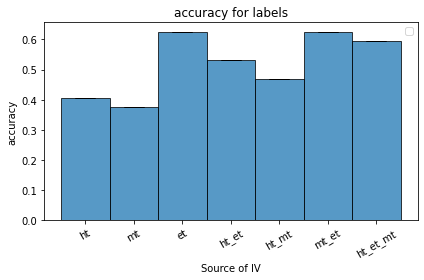

Row index 14
IV: ['human_t2c'] 
DV: ['labels']
Metrics
	accuracy: 0.4062
		 'human_t2c' sensitivity: 0.0438
	recall: 0.3791
		 'human_t2c' sensitivity: 0.0438
	recall_per_class: [0.52631579 0.5        0.11111111]
	f1: 0.3304
		 'human_t2c' sensitivity: 0.0278
	f1_per_class: [0.54054054 0.30769231 0.14285714]
Row index 15
IV: ['model_t2c'] 
DV: ['labels']
Metrics
	accuracy: 0.3750
		 'model_t2c' sensitivity: 0.0289
	recall: 0.4591
		 'model_t2c' sensitivity: 0.0289
	recall_per_class: [0.21052632 0.5        0.66666667]
	f1: 0.3611
		 'model_t2c' sensitivity: 0.0130
	f1_per_class: [0.33333333 0.25       0.5       ]
Row index 16
IV: ['explainer_t2c'] 
DV: ['labels']
Metrics
	accuracy: 0.6250
		 'explainer_t2c' sensitivity: 0.1170
	recall: 0.4678
		 'explainer_t2c' sensitivity: 0.1170
	recall_per_class: [0.73684211 0.         0.66666667]
	f1: 0.4259
		 'explainer_t2c' sensitivity: 0.1130
	f1_per_class: [0.77777778 0.         0.5       ]
Row index 17
IV: ['human_t2c', 'explainer_t2c'] 
DV: [

In [24]:
logreg_df_path = os.path.join(cur_group_save_dir, 'logreg_results', 'sensitivity.csv')
# logreg_df_path = 'saved/ADE20K/survey_results/group_1_3/logreg_results/sensitivity.csv'
logreg_df = pd.read_csv(logreg_df_path)
ivs = ['t2c']
dv = 'labels'
metrics = ['accuracy', 'recall', 'recall_per_class', 'f1', 'f1_per_class']
drop_correlated = True

cur_logreg_df = filter_df(logreg_df,
    ivs=ivs,
    dv=dv)

# Drop rows that have correlated variables
if drop_correlated:
    drop_idxs = []
    for idx, row in cur_logreg_df.iterrows():
        row_ivs = string_to_list(row['iv'], dtype='string')
        row_ivs = [word.replace("'", "") for word in row_ivs]
        
        # if len(row_ivs) > 2:
        #     drop_idxs.append(row['Unnamed: 0'])
        if len(row_ivs) == 2:
            var1, var2 = row_ivs
            if (var1, var2) in low_corr_set or (var2, var1) in low_corr_set:
                print("({}, {}) has low correlation".format(var1, var2))
            elif (var1, var2) in med_corr_set or (var2, var1) in med_corr_set:
                print("({}, {}) has moderate correlation".format(var1, var2))
            else:
                drop_idxs.append(row['Unnamed: 0'])
                print("Dropping ({}, {})".format(var1, var2))
    cur_logreg_df = cur_logreg_df.drop(drop_idxs, axis=0)

log_path = 'temp/temp.txt'
highest_acc_row = cur_logreg_df.loc[cur_logreg_df['accuracy'].idxmax()]
print("Highest accuracy with {}: {:.4f}".format(
    highest_acc_row['iv'],
    highest_acc_row['accuracy']))

plot_metric_v_inputs(
    df=cur_logreg_df,
    ivs=ivs,
    dv=dv,
    graph_metric='accuracy')
print_summary(
    df=cur_logreg_df,
    metrics=metrics,
    log_path=log_path)

#### Partition Samples into low/med/high confusion groups (ditched)